# **Classification Simulation to Predict Service or not**
Motorcycle Condition Data that contains 550 records and 14 columns.

**Data Overview:**
*   **Vehicle Metrics**: mileage_km, engine_hours, last_service_km, oil_quality_pct, brake_pad_thickness_mm, tire_pressure_psi, avg_engine_temp_C, error_code_count
*   **Environmental Metrics**: ambient_temp_C, humidity_pct
*   **Status Indicators**: check_engine_light, usage_type, needs_service



# **Steps for Analysis and Preprocessing**



*   Exploratory Data Analysis (EDA)
*   Data Preprocessing
*   Modelling
*   Model Evaluation
*   Hyperparameter Tuning


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the CSV file
file_path = "https://raw.githubusercontent.com/frfusch21/Manufacture-Otomotive-Analysis/refs/heads/main/Data/Predictive_Service_Data.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,vehicle_id,mileage_km,engine_hours,last_service_km,oil_quality_pct,brake_pad_thickness_mm,tire_pressure_psi,avg_engine_temp_C,check_engine_light,error_code_count,usage_type,ambient_temp_C,humidity_pct,needs_service
0,10102,52475.341972,1063.876707,8163.878920,31.121750,9.632146,34.487389,88.250554,0,2,commercial,19.404684,64.833831,1
1,10435,37161.066233,1389.882490,6466.216214,67.712064,7.851578,31.918004,79.301047,0,0,private,26.293588,38.161442,0
2,10860,49405.457869,742.034441,11512.248572,60.577925,10.174928,30.031412,77.353136,0,0,commercial,25.822869,25.925413,0
3,10270,41980.058872,1182.628528,6860.357566,36.459373,9.848324,29.801321,105.292966,0,1,private,26.194735,28.349017,1
4,10106,23172.552425,1445.545420,10078.433569,21.789255,7.154733,31.791265,91.316446,0,0,private,13.711545,35.720767,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_id              550 non-null    int64  
 1   mileage_km              550 non-null    float64
 2   engine_hours            550 non-null    float64
 3   last_service_km         550 non-null    float64
 4   oil_quality_pct         550 non-null    float64
 5   brake_pad_thickness_mm  550 non-null    float64
 6   tire_pressure_psi       550 non-null    float64
 7   avg_engine_temp_C       550 non-null    float64
 8   check_engine_light      550 non-null    int64  
 9   error_code_count        550 non-null    int64  
 10  usage_type              550 non-null    object 
 11  ambient_temp_C          550 non-null    float64
 12  humidity_pct            550 non-null    float64
 13  needs_service           550 non-null    int64  
dtypes: float64(9), int64(4), object(1)
memory 

## EDA

In [5]:
df.isnull().sum()

,0
vehicle_id,0
mileage_km,0
engine_hours,0
last_service_km,0
oil_quality_pct,0
brake_pad_thickness_mm,0
tire_pressure_psi,0
avg_engine_temp_C,0
check_engine_light,0
error_code_count,0


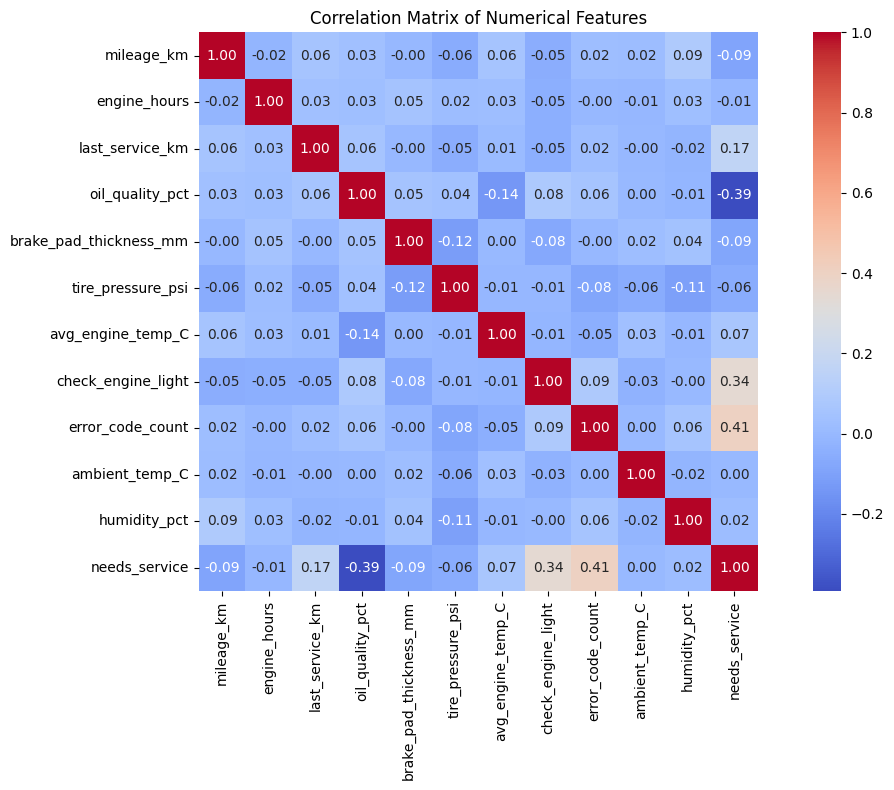

In [6]:
# Check Correlation
numerical_features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['vehicle_id']).columns
corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

**Insights**
*   *last_service_km* and *needs_service* are positively correlated with 0.17.
*   *oil_quality_pct* has a negative correlation with *needs_service* with -0.39.
*   *check_engine_light* shows a postive correlation with *needs_service* with 0.34.
*   *error_code_count* has a positive correlation with *needs_service* with 0.41.









Visualize how some key features differ between Motorcycle that need service vs. those that don't.

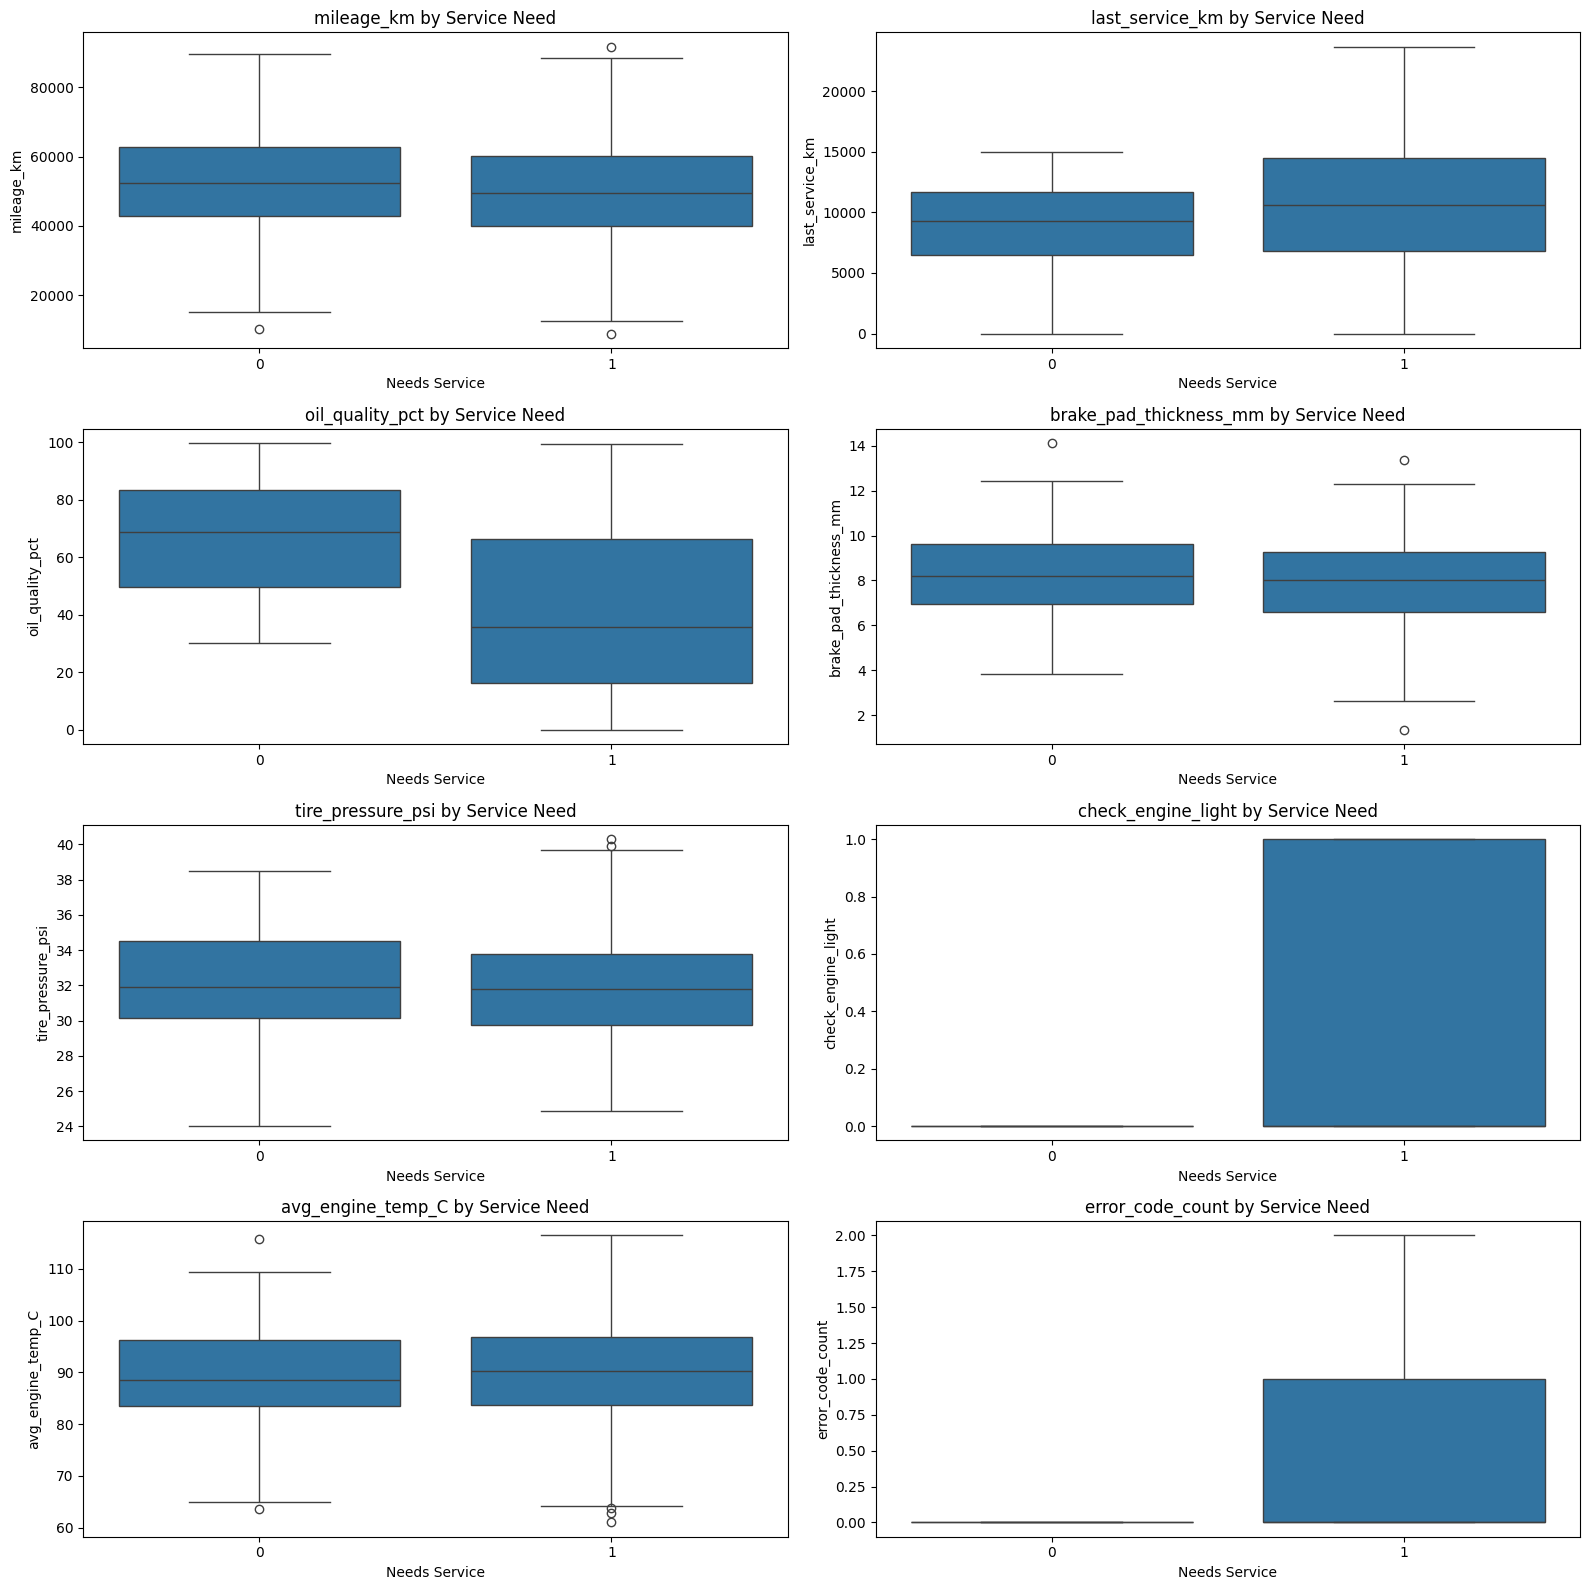

In [7]:
features_to_plot = [
    'mileage_km','last_service_km', 'oil_quality_pct',
    'brake_pad_thickness_mm', 'tire_pressure_psi', 'check_engine_light',
    'avg_engine_temp_C', 'error_code_count'
]

# Plot distributions by service need
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=df, x='needs_service', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Service Need')
    axes[i].set_xlabel('Needs Service')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

**Insights**
*   Motorcycle that need service generally have slightly higher mileage on average. The interquartile range (IQR) is similar, but the upper bound extends a bit further for those needing service, implying some high-mileage motorcycle require attention.
*   Both groups have similar distributions, but Motorcycle needing service tend to have a wider range since the last service (some are far overdue). Longer gaps since last service may increase the likelihood of needing service.
*   Motorcycle needing service show much lower oil quality percentages.
*   Motorcycle needing service have thinner brake pads on average. Decreased brake pad thickness correlates with the need for service.
*   The presence of the check engine light is almost perfectly aligned with service needs. Motorcycle not needing service almost never have the light on.
*   Same as *error_code_count*  that it is aligned with service needs with Motorcycle not needing service almost never have error code.
*   Higher engine temperature may be a contributing factor but is not a strong standalone indicator.

## Data Preprocessing

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [9]:
# Drop identifier
df_model = df.drop(columns=['vehicle_id'])

### Data Encoding

In [10]:
# Encode categorical feature
df_model['usage_type'] = LabelEncoder().fit_transform(df_model['usage_type'])

### Train Test Split & Data Scaling (Standarization)

In [11]:
X = df_model.drop(columns=['needs_service'])
y = df_model['needs_service']

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Stratify since this data is a bit imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((440, 12),
 (110, 12),
 needs_service
 1    293
 0    147
 Name: count, dtype: int64,
 needs_service
 1    73
 0    37
 Name: count, dtype: int64)

## Modelling

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
# Trying 3 different model
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:02:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [14]:
# Predictions and probabilities
y_pred_logreg = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)

y_proba_logreg = log_reg.predict_proba(X_test)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

## Model Evaluation

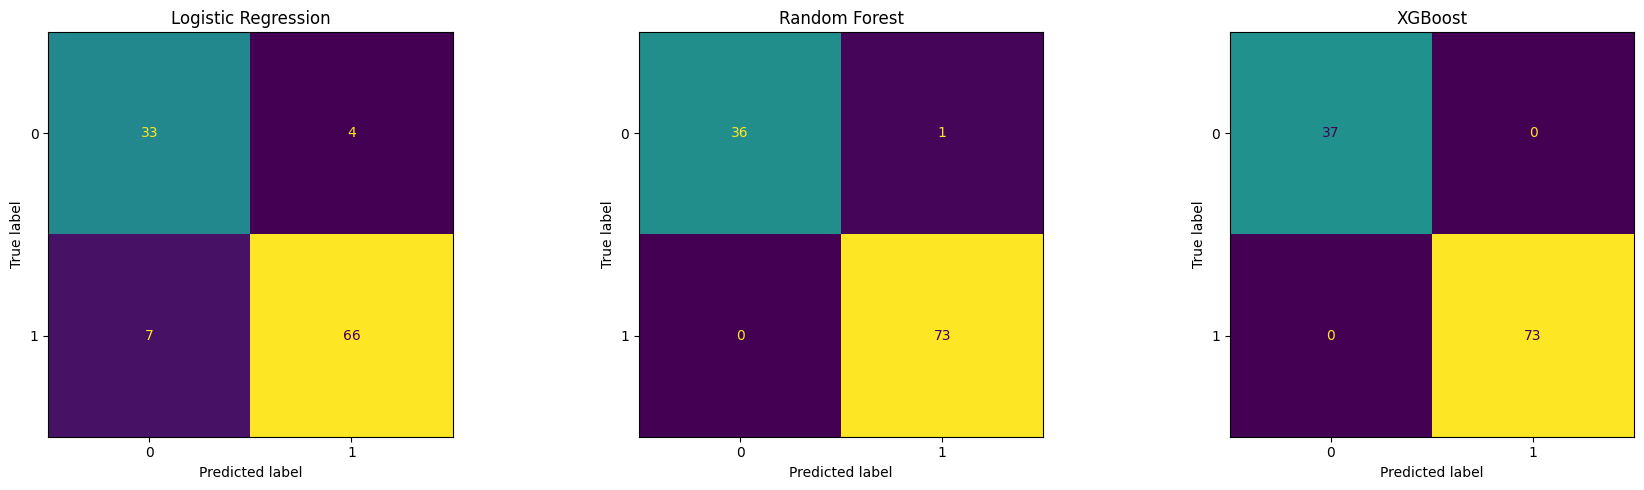

In [15]:
# Display confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, ax=axes[0], colorbar=False)
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[1], colorbar=False)
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, ax=axes[2], colorbar=False)
axes[2].set_title("XGBoost")

plt.tight_layout()
plt.show()

In [16]:
# Training set predictions
train_preds_logreg = log_reg.predict(X_train)
train_preds_rf = rf.predict(X_train)
train_preds_xgb = xgb.predict(X_train)

# Accuracy scores (Check for overfitting)
overfit_check = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Train Accuracy": [
        accuracy_score(y_train, train_preds_logreg),
        accuracy_score(y_train, train_preds_rf),
        accuracy_score(y_train, train_preds_xgb)
    ],
    "Test Accuracy": [
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ]
})
overfit_check

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.918182,0.900000
1,Random Forest,1.000000,0.990909
2,XGBoost,1.000000,1.000000


**Insights**
*   **Logistic Regression**: Small difference, the dataset is likely well-generalized.
*   **Random Forest & XGBoost**: Perfect training accuracy but may indicate mild overfitting, though high test accuracy suggests strong generalization for this dataset.



In [17]:
# Training set predictions
train_proba_logreg = log_reg.predict_proba(X_train)[:, 1]
train_proba_rf = rf.predict_proba(X_train)[:, 1]
train_proba_xgb = xgb.predict_proba(X_train)[:, 1]

overfit_check_auc = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Train ROC AUC": [
        roc_auc_score(y_train, train_proba_logreg),
        roc_auc_score(y_train, train_proba_rf),
        roc_auc_score(y_train, train_proba_xgb)
    ],
    "Test ROC AUC": [
        roc_auc_score(y_test, y_proba_logreg),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

overfit_check_auc

,Model,Train ROC AUC,Test ROC AUC
0,Logistic Regression,0.975598,0.970381
1,Random Forest,1.000000,1.000000
2,XGBoost,1.000000,1.000000


**Insights**
*   Logistic Regression shows excellent generalization with nearly identical AUC on train and test sets.
*   Random Forest & XGBoost have perfect or near-perfect AUCs, reinforcing strong discriminative ability but again their perfect train scores hint at mild overfitting.
*   We could try SMOTE for class imbalance in case in the future the data we collected biased towards needing service but for now it is not needed since the ratio is about 2:1 give or take.





## Hyperparameter Tuning

In [22]:
# Hyperparameter tuning for XGBoost
enable_tuning = True

if enable_tuning:
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }

    tuner = RandomizedSearchCV(
        estimator=XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        param_distributions=param_grid,
        n_iter=10,
        scoring="roc_auc",
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    tuner.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:16:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [29]:
baseline_model = xgb
baseline_pred = baseline_model.predict(X_test)
baseline_proba = baseline_model.predict_proba(X_test)[:, 1]
baseline_report = pd.DataFrame(classification_report(y_test, baseline_pred, output_dict=True)).transpose()
print("=== Baseline XGBoost Report ===")
baseline_report.round(3)

=== Baseline XGBoost Report ===


,precision,recall,f1-score,support
0,1.0,1.0,1.0,37.0
1,1.0,1.0,1.0,73.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,110.0
weighted avg,1.0,1.0,1.0,110.0
roc_auc,NaN,NaN,NaN,1.0


In [30]:
# Final model with best params
tuned_pred = tuner.predict(X_test)
tuned_proba = tuner.predict_proba(X_test)[:, 1]
tuned_report = pd.DataFrame(classification_report(y_test, tuned_pred, output_dict=True)).transpose()
print("\n=== Tuned XGBoost Report ===")
tuned_report.round(3)


=== Tuned XGBoost Report ===


,precision,recall,f1-score,support
0,1.0,1.0,1.0,37.0
1,1.0,1.0,1.0,73.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,110.0
weighted avg,1.0,1.0,1.0,110.0
roc_auc,NaN,NaN,NaN,1.0
